# Single Particle Model (SPM): External short circuit (simulations at different initial SOC vs data)

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($\text{k}=\text{n}$) and one within a representative positive particle ($\text{k}=\text{p}$). In the centre of the particle the standard no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current $I$ divided by the thickness of the electrode $L_{\text{k}}$. The concentration of lithium in electrode $\text{k}$ is denoted $c_{\text{k}}$ and the current is denoted by $I$. All parameters in the model stated here are dimensionless and are given in terms of dimensional parameters at the end of this notebook. The model equations for the SPM are then: 
\begin{align}
\mathcal{C}_{\text{k}} \frac{\partial c_{\text{s,k}}}{\partial t} &= -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} &= -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, \end{align}
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0, \quad \text{k} \in \text{n, p}, \quad \ \ - \frac{a_{R, \text{k}}\gamma_{\text{k}}}{\mathcal{C}_{\text{k}}} N_{\text{s,k}}\big|_{r_{\text{k}}=1} = 
\begin{cases}
		  \frac{I}{L_{\text{n}}}, \quad &\text{k}=\text{n}, \\ 
		  -\frac{I}{L_{\text{p}}}, \quad &\text{k}=\text{p}, 
\end{cases} \\
c_{\text{s,k}}(r_{\text{k}},0) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle within the region $\text{k}$, and $r_{\text{k}} \in[0,1]$ is the radial coordinate of the particle in electrode $\text{k}$. 

### Voltage Expression
The terminal voltage is obtained from the expression: 
$$
V = U_{\text{p}}(c_{\text{p}})\big|_{r_{\text{p}}=1} - U_{\text{n}}(c_{\text{n}})\big|_{r_{\text{n}}=1} -2\sinh^{-1}\left(\frac{I}{j_{\text{0,p}} L_{\text{p}}}\right) - 2\sinh^{-1}\left(\frac{I}{j_{\text{0,n}} L_{\text{n}}}\right)
$$
with the exchange current densities given by
$$j_{\text{0,k}} =  \frac{\gamma_{\text{k}}}{\mathcal{C}_{\text{r,k}}}(c_{\text{k}})^{1/2}(1-c_{\text{k}})^{1/2}  $$

More details can be found in [[3]](#References).

## Example solving SPM using PyBaMM

Below we show how to solve the Single Particle Model, using the default geometry, mesh, parameters, discretisation and solver provided with PyBaMM. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](../simulation-class.ipynb).

First we need to import `pybamm`, and then change our working directory to the root of the pybamm folder. 

In [1]:
# need to restart jupyter server? kernal? whenever a change is made to the pybamm module? 
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir(sys.path[0] + '\..') # change our working directory to the root of the pybamm folder
import pybamm
print(pybamm.__path__[0])
%matplotlib inline
import inspect

c:\Users\Vivian\Dropbox (University of Michigan)\from_box\Research\PyBaMM\PyBaMM\pybamm


In [2]:
class ExternalCircuitResistanceFunction():
    def __call__(self, variables):
        I = variables["Current [A]"]
        V = variables["Terminal voltage [V]"]
        R_ext = pybamm.FunctionParameter("External resistance [Ohm]",  {"Time [s]": pybamm.t}) 
        R_tab = pybamm.FunctionParameter("Tabbing resistance [Ohm]",  {"Time [s]": pybamm.t})
        return V/I - (R_ext + R_tab)

In [3]:
from pybamm import exp, constants, Parameter


def modified_graphite_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Negative electrode diffusion coefficient [m2.s-1]")
    m = Parameter("Diffusion stoichiometry scalar")
    b = Parameter("Diffusion stoichiometry offset")
    # D_ref = 16*5.0 * 10 ** (-15)
    E_D_s = 42770
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref #*(m * sto + b) #* arrhenius # 

def modified_NMC_diffusivity_PeymanMPM(sto, T):
    D_ref =  Parameter("Positive electrode diffusion coefficient [m2.s-1]")
    m = Parameter("Diffusion stoichiometry scalar")
    b = Parameter("Diffusion stoichiometry offset")

    # D_ref = 8 * 10 ** (-15)
    E_D_s = 18550
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius #* (10 * sto + 0.1) * 0.5#* (m * sto + b)

def modified_electrolyte_diffusivity_PeymanMPM(c_e, T):
    # D_c_e = 5.35 * 10 ** (-10)
    D_c_e =  Parameter("Typical electrolyte diffusivity [m2.s-1]")
    E_D_e = 37040
    arrhenius = exp(E_D_e / constants.R * (1 / 298.15 - 1 / T))

    return D_c_e * arrhenius #* (2* c_e + 1) 

In [16]:
solutions = []
SOC_0 = [1,0.75,0.5]
h = 0.5
R_tab = pybamm.Parameter("Tabbing resistance [Ohm]")
R_ext = pybamm.Parameter("External resistance [Ohm]")
data_sets = []

for j, soc in enumerate(SOC_0):
    # load data import ESC data from file
    data = pd.read_csv("./fast_discharge/ESC_"+  str(int(soc*100)) + "SOC_full.csv")
    data['Current Shunt'] = -data['Current Shunt']
    esc_start = data[data['Current Shunt']>1].index[0]
    data = data.loc[esc_start::]
    data['Time (s)'] = data['Time (s)'] - data['Time (s)'].loc[esc_start]
    # print([key for key in data.keys()])
    # data.head()
    data_sets.append(data)

    options = {
        "thermal": "x-lumped",
        # "intercalation kinetics": "high-current Butler-Volmer",
#         "side reactions": "decomposition", 
        "operating mode": ExternalCircuitResistanceFunction(),
    }
    model = pybamm.lithium_ion.SPM(options = options)
    param = pybamm.ParameterValues(pybamm.parameter_sets.Mohtat2020)
    param.update({
        "Tabbing resistance [Ohm]":  0.0095,#0.0041,
        "External resistance [Ohm]": 0.0067, # 0.0067
        "Cell capacity [A.h]": 4.6, #nominal
        "Typical current [A]": 4.6,
        "Lower voltage cut-off [V]": 0,
        "Ambient temperature [K]":296.7,
        "Initial temperature [K]": 296.7,
        "Negative tab width [m]":2.5e-2,
        "Positive tab width [m]":2.5e-2,
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,  
        "Negative tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Positive tab heat transfer coefficient [W.m-2.K-1]":h,  
        "Edge heat transfer coefficient [W.m-2.K-1]":h,
        "Total heat transfer coefficient [W.m-2.K-1]":h,
        # "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        # "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
        "Negative electrode diffusivity [m2.s-1]": modified_graphite_diffusivity_PeymanMPM,
        "Positive electrode diffusivity [m2.s-1]": modified_NMC_diffusivity_PeymanMPM,
        "Electrolyte diffusivity [m2.s-1]": modified_electrolyte_diffusivity_PeymanMPM,
        "Diffusion stoichiometry scalar": 2,
        "Diffusion stoichiometry offset": 1,

    }, check_already_exists = False)

    V = model.variables["Terminal voltage [V]"]
    I = model.variables["Current [A]"]
    model.variables.update({
        "Terminal voltage [V]": V - I*R_tab,
        "Actual resistance [Ohm]":V/I,
        }
    )
    dt = 0.1
    t_eval = np.arange(0, 10*60, dt)
    solver = pybamm.CasadiSolver(mode="safe", dt_max= 1e-6, extra_options_setup={"max_num_steps": 10000})
    sim = pybamm.Simulation(model, parameter_values = param, solver=solver)
    solution = sim.solve( initial_soc=soc, t_eval = t_eval)
    solutions.append(solution)

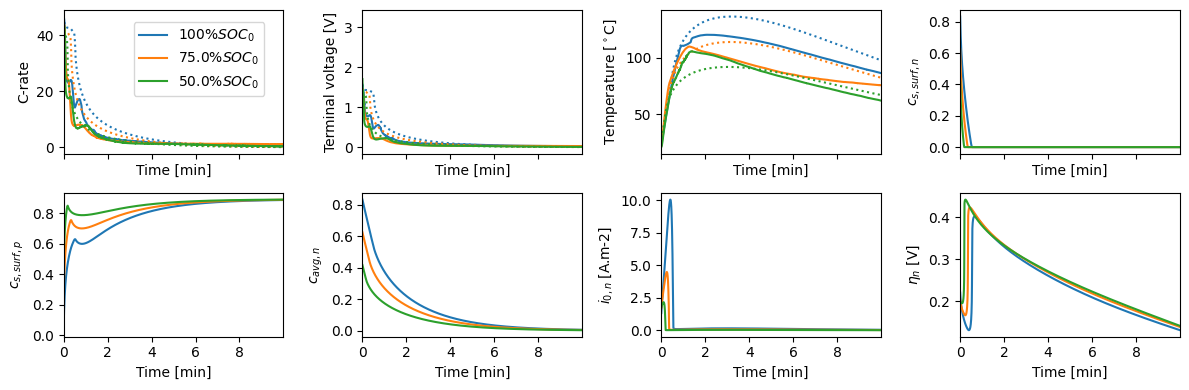

In [27]:
labels = [str(soc*100) + '$\%SOC_0$' for soc in SOC_0]
fig, ax = plt.subplots(2, 4, figsize=(12,4), sharex=True)
ax = ax.flatten()
linestyles = ['-','--',':','.-']*2

for l, solution in enumerate(solutions):
    data = data_sets[l]
    t = solution["Time [s]"].entries
    # AhT = solution["Discharge capacity [A.h]"].entries
    x_plot = t/60
    xlabel = "Time [min]"
    # x_plot = solution["Discharge capacity [A.h]"].entries
    # xlabel = "AhT"

    I = solution['C-rate']
    line, = ax[0].plot(data['Time (s)']/60,data['Current Shunt']/param['Nominal cell capacity [A.h]'], label=labels[l],)
    ax[0].plot(x_plot, I(t), linestyle=':',color = line.get_color())
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('C-rate')


    V = solution['Terminal voltage [V]']
    ax[1].plot(data['Time (s)']/60,data['Voltage (V)'])
    ax[1].plot(x_plot, V(t), linestyle=':',color = line.get_color())
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Terminal voltage [V]')

    T = solution['Volume-averaged cell temperature [K]'].entries - 273.15
    ax[2].plot(data['Time (s)']/60,data['Cell Temperature'])
    ax[2].plot(x_plot, T,linestyle=':',color = line.get_color())  # can evaluate at arbitrary x (single representative particle)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel('Temperature [$^\circ$C]')


    c_s_n_surf = solution['Negative particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[3].plot(x_plot, c_s_n_surf(t=t, x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    ax[3].set_xlabel(xlabel)
    ax[3].set_ylabel('$c_{s,surf,n}$')

    c_s_p_surf = solution['Positive particle surface concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[4].plot(x_plot, c_s_p_surf(t=t, x=x[-1]))  # can evaluate at arbitrary x (single representative particle)
    ax[4].set_xlabel(xlabel)
    ax[4].set_ylabel('$c_{s,surf,p}$')

    soc = solution['R-averaged negative particle concentration']
    x = solution["x [m]"].entries[:, 0]
    ax[5].plot(x_plot, soc(t=t, x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    ax[5].set_xlabel(xlabel)
    ax[5].set_ylabel('$c_{avg,n}$')

    i0 = solution[ 'Negative electrode exchange current density [A.m-2]']
    x = solution["x [m]"].entries[:, 0]
    ax[6].plot(x_plot, i0(t=t, x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    ax[6].set_xlabel(xlabel)
    ax[6].set_ylabel('$i_{0,n}$ [A.m-2]')

    eta = solution['Negative electrode reaction overpotential [V]']
    x = solution["x [m]"].entries[:, 0]
    ax[7].plot(x_plot, eta(t=t, x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    ax[7].set_xlabel(xlabel)
    ax[7].set_ylabel('$\eta_n$ [V]')

plt.xlim([t_eval[0],t_eval[-1]/60])
lines_labels = [ax.get_legend_handles_labels() for ax in ax]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.17, 0.95), fancybox=True)
# fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), fancybox=True, ncol = len(labels))

plt.tight_layout()
plt.show()


In [28]:
print(I(0))
print(data['Current Shunt'].iloc[0]/param['Nominal cell capacity [A.h]'])
print(V(0))
print(data['Voltage (V)'].iloc[0])

41.64330152170961
45.39929422
1.3950506012687849
1.704639075


In [8]:
solution = solutions[0]
quick_plot = pybamm.QuickPlot(solution, output_variables=[ #, figsize=[7,7],n_rows = 4,
    'Current [A]', 
    # 'X-averaged negative electrode exchange current density [A.m-2]',
    # 'X-averaged positive electrode exchange current density [A.m-2]',

    'Terminal voltage [V]',
    # 'X-averaged negative particle surface concentration',
    # 'X-averaged positive particle surface concentration',

    'Volume-averaged cell temperature [K]',
    # 'X-averaged negative particle concentration', 
    # 'X-averaged positive particle concentration',

    'Discharge capacity [A.h]',
    # 'Negative electrolyte concentration',
    # 'Positive electrolyte concentration',
    ])
quick_plot.dynamic_plot();

In [ ]:
display([k for k in model.variables.keys()])

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosity',
 'X-averaged separator porosity',
 'X-averaged positive electrode porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Leading-order porosity',
 'Leading-order separator porosity',
 'Leading-order positive electrode porosity',
 'Leading-order x-averaged separator porosity',
 'Leading-order x-averaged positive electrode porosity',
 'Leading-order negative electrode porosity',
 'Leading-order x-averaged negative electrode porosity',
 'Porosity change',
 'Separator porosity change',
 'Positive elect

In [ ]:
print(inspect.getsource(param['Negative electrode exchange-current density [A.m-2]']))


def graphite_electrolyte_exchange_current_density_PeymanMPM(c_e, c_s_surf, c_s_max, T):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.
    Check the unit of Reaction rate constant k0 is from Peyman MPM.

    References
    ----------
    .. [2] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref conc

## Dimensionless Parameters

In the table below, we provide the dimensionless parameters in the SPM in terms of the dimensional parameters in LCO.csv. We use a superscript * to indicate dimensional quantities. 

| Parameter                 | Expression                              |Interpretation                             |
|:--------------------------|:----------------------------------------|:------------------------------------------|
| $L_{\text{k}}$            | $L_{\text{k}}^*/L^*$                    | Ratio of region thickness to cell thickness|
|$\mathcal{C}_{\text{k}}$   | $\tau_{\text{k}}^*/\tau_{\text{d}}^*$   | Ratio of solid diffusion and discharge timescales |
|$\mathcal{C}_{\text{r,k}}$ |$\tau_{\text{r,k}}^*/\tau_{\text{d}}^*$  |Ratio of reaction and discharge timescales|
|$a_{R, \text{k}}$             |$a_{\text{k}}^* R_{\text{k}}^*$          | Product of particle radius and surface area to volume ratio|
|$\gamma_{\text{k}}$        |$c_{\text{k,max}}^*/c_{\text{n,max}}^*$  |Ratio of maximum lithium concentrations in solid|

## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(782

In [ ]:
param.search('Diffusivity')

EC diffusivity [m2.s-1]	2e-18
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x000001C23D99EC10>
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Negative electrode diffusivity [m2.s-1]	<function graphite_diffusivity_PeymanMPM at 0x000001C23D99E940>
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Positive electrode diffusivity [m2.s-1]	<function NMC_diffusivity_PeymanMPM at 0x000001C23D99E700>
Typical electrolyte diffusivity [m2.s-1]	5.35e-10
